In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
plt.rcParams['figure.figsize'] = 20, 15

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train17': transforms.Compose([
        transforms.ToTensor(),
        lambda x: x[:1],
        transforms.Normalize([0.], [1.])
    ]),
    'val17': transforms.Compose([
        transforms.ToTensor(),
        lambda x: x[:1],
        transforms.Normalize([0.], [1.])
    ]),
}

data_dir = './mnist_png/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train17', 'val17']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train17', 'val17']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train17', 'val17']}
class_names = image_datasets['train17'].classes

use_gpu = torch.cuda.is_available()

# Visualize a few images



Let's visualize a few training images so as to understand the data.


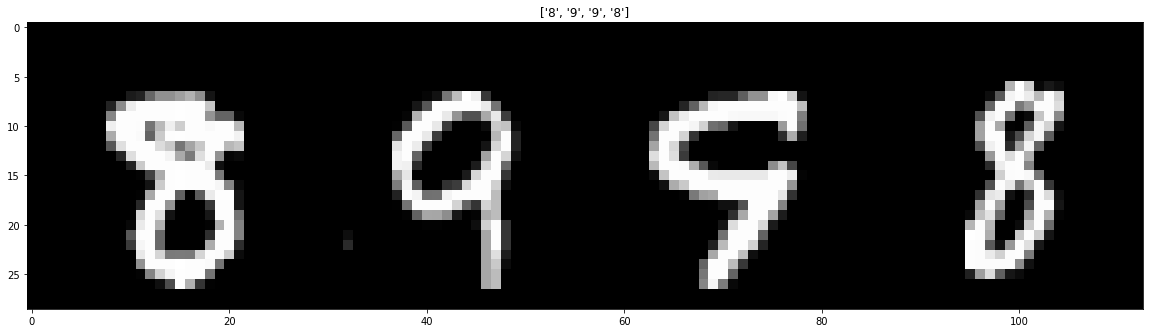

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0])
    std = np.array([1])
    inp = std * inp + mean
    plt.imshow(inp.squeeze())
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train17']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, padding=0)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
inputs.shape

torch.Size([4, 1, 28, 28])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train17', 'val17']:
            if phase == 'train17':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels[:, None].float().cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                preds = (outputs.data > .5).float()
                
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train17':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val17' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions


Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val17']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        preds = (outputs.data > .5).squeeze().int().cpu().tolist()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
class Perceptron(nn.Module):
    def __init__(self, in_features):
        super(Perceptron, self).__init__()
        self.lin = nn.Linear(in_features=in_features, out_features=1)
    
    def forward(self, input):
        return nn.functional.sigmoid(self.lin(input.view(input.size(0), -1)))
    
model_ft = Perceptron(28*28)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------


TypeError: is_same_size received an invalid combination of arguments - got ([31;1mtorch.FloatTensor[0m), but expected (torch.LongTensor other)

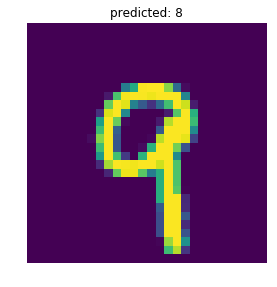

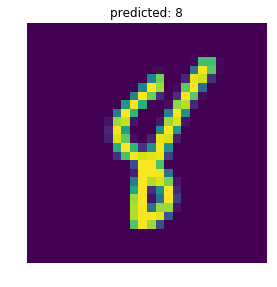

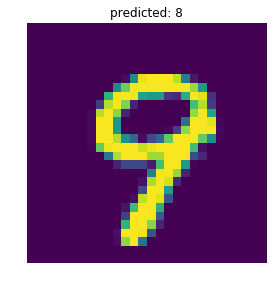

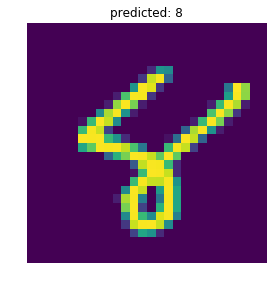

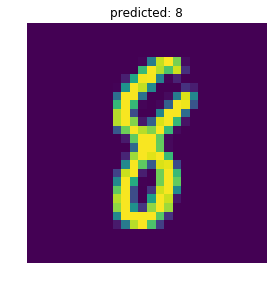

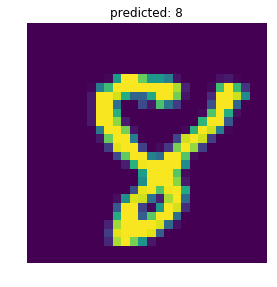

In [10]:
visualize_model(model_ft)

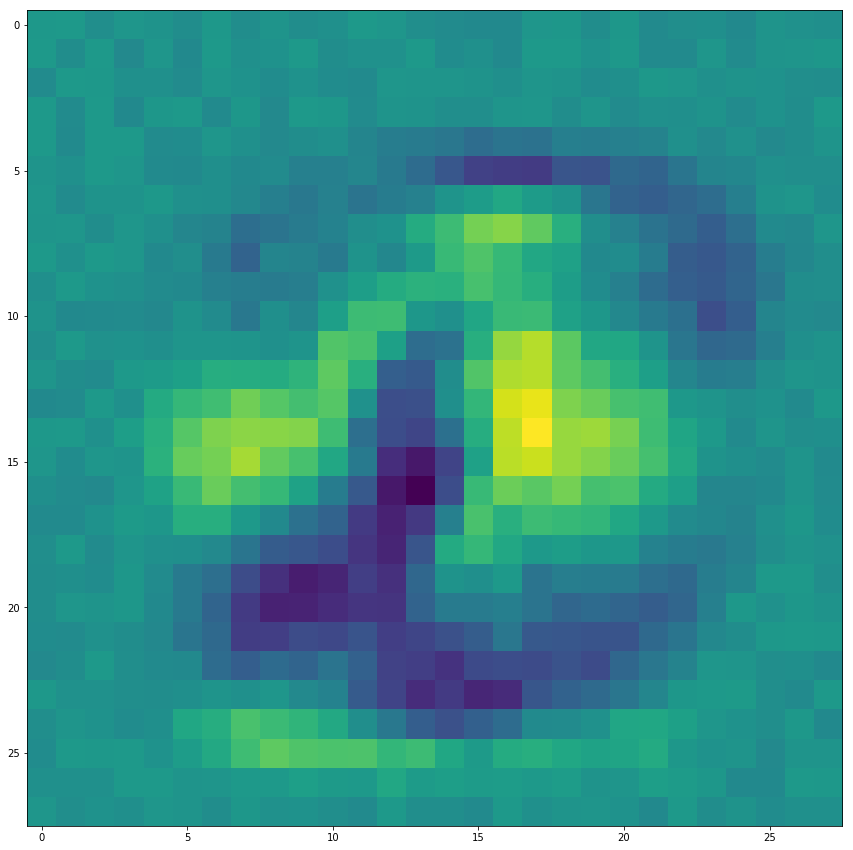

In [14]:
plt.imshow(model_ft.lin.weight.data.cpu().numpy().reshape(28, 28))